In [ ]:
# ドライブをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 入力ディレクトリを指定
ind="/content/drive/MyDrive/RNA-seq-test/Inputs/HaCaT_Data1" #@param {type:"string"}
# 出力ディレクトリを指定
oud="/content/drive/MyDrive/RNA-seq-test/Outputs/HaCaT_Data1" #@param {type:"string"}
oud = oud + "/"

# カレントディレクトリの変更
import os
os.makedirs(ind , exist_ok = True)
os.makedirs(oud , exist_ok = True)
os.chdir(ind)
currentdir = os.getcwd()

# 必要なモジュールをインポートする
import pandas as pd
import numpy as np
import urllib.parse
from google.colab import files
import re
!pip install scipy
from scipy.cluster.hierarchy import linkage , dendrogram , fcluster
import matplotlib.pyplot as plt

In [ ]:
# 実験名を設定する
exp_name = "HaCaT_Data1" #@param {type:"string"}
exp_name = exp_name + "_"


In [ ]:
# gtfファイルのパスを指定
gtf_path = "/content/drive/MyDrive/RNA-seq-test/SourceFiles/Homo_sapiens.GRCh38.94.gtf" #@param {type:"string"}


In [ ]:
# gene_idとproductの対応表作成
# 出力用のリストを定義
outputlist = []
# 出力用のcsvを作成
fout = open(exp_name + '_id_name.csv', 'w')
# gtfファイルを開く
with open(gtf_path, 'r') as fin:
    # gtfデータを1行ずつ読み込む
    for line in fin:
      # 出力用の変数を定義
        product = ''
        geneid = ''
        
        # 行末の空白を削除
        line=line.rstrip()
        # #で始まっているデータ行を除く
        if not line.startswith('#'):
            # gtfをタブ区切りで認識し、その9列目(1列目が0なので8)を読む
            s=line.split('\t')
            items=s[8].split(';')
            
            # 各行の9列目について
            for item in items:
                # ' gene_name "'で始まる要素なら、"で分割して=の右側を取出し、url逆変換する
                if item.startswith(' gene_name "'):
                    product = item.split('"')[1]
                    product = urllib.parse.unquote(product)

                # 'gene_id "'で始まる要素なら、"で分割して右側を取出す
                if item.startswith('gene_id "'):
                    geneid = item.split('"')[1]

                # gene_name と gene_idが両方あれば、出力リストに取り込む
                if (geneid != '') and (product != ''):
                    outputlist.append(geneid+','+product)

# 重複を除去、並び順をソートの上で、ヘッダーを追加する
outputlist = sorted(list(set(outputlist)))
outputlist.insert(0 , "Geneid"+','+"product")
  
# csvに書き込んでいく
fout = open(exp_name + "id_name.csv", "w")
for u in outputlist:
    print(u, file=fout)
fout.close()

# csvをData frameとして認識後、ヘッダーを除去して再保存する
df_id_name = pd.read_csv(exp_name + 'id_name.csv')
df_id_name.to_csv(oud + exp_name + 'id_name.csv' ,sep = ',' , index=False , header=False) 

In [ ]:
# カウントデータをDataFrame化
!rm -f file1.txt
!ls *.txt > file1.txt
drop_col = ['Chr' , 'Start' , 'End' , 'Strand']
df2 = df_id_name.copy()
j=0

with open("file1.txt") as file1:
  for i in file1:
    i = i.replace("\n" , "")
    df = pd.read_csv(i , skiprows = 1 , sep = "\t")
    df.drop(drop_col, axis=1 , inplace = True)
    x = list(df.columns.values)[2]
    y = re.sub("/.*", "", x) #遺伝研用
 #   y = re.sub("/.*/" , "" , x) #nanopore用
 #   y= re.sub(".bam$" , "" , y) #nanopore用

    df.columns = (["Geneid" , "Length" , y])
    if j == 0:
      df2 = pd.merge(df2 , df , how="outer" , on=["Geneid"])
      j = 1
    else:
      df2 = pd.merge(df2 , df , how="outer" , on=["Geneid" , "Length"])

In [ ]:
# TPMの計算式を定義

def normalize_per_million_reads(df):
    # RPM/FPM = reads per million  fragments per million
    sum = df.sum()
    return 10**6 * df / sum

def normalize_per_kilobase(df, gene_length):
    # FPKM = fragments per kilobase of exon per million reads mapped
    ret = ((df.copy().T) * 10**3 / gene_length).T
    return ret

def normalize_tpm(df, gene_length):
    # TPM = transcripts per kilobase million
    df_tmp = df.copy()
    df_tmp = normalize_per_kilobase(df_tmp, gene_length)
    df_tmp = normalize_per_million_reads(df_tmp)
    return df_tmp

In [ ]:
# カウントデータをTPM正規化
df_count = df2.copy() 
df_count.set_index(["Geneid" , "product"] , inplace = True)
gene_length = df_count["Length"] 
df_count.drop(["Length"] , axis = 1 , inplace = True)

# TPMによる正規化
df_tpm = normalize_tpm(df_count, gene_length)

df_tpm.dropna(how="any" , inplace = True)

df_tpm.to_csv(oud + exp_name + "tpm.csv", sep=",")

df_tpm

,,SRR16203174,SRR16203175,SRR16203176,SRR16203177
Geneid,product,,,,
ENSG00000000003,TSPAN6,19.495305,19.562800,20.496433,18.929919
ENSG00000000005,TNMD,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,DPM1,250.374827,264.105769,241.269611,253.986941
ENSG00000000457,SCYL3,8.512574,9.319981,10.161786,10.186933
ENSG00000000460,C1orf112,23.262501,22.975493,26.814562,27.976978
...,...,...,...,...,...
ENSG00000285990,AL589743.7,0.000000,0.000000,0.000000,0.000000
ENSG00000285991,AL355312.5,0.172143,0.059883,0.000000,0.096302
ENSG00000285992,AC120036.5,0.000000,0.000000,0.000000,0.000000


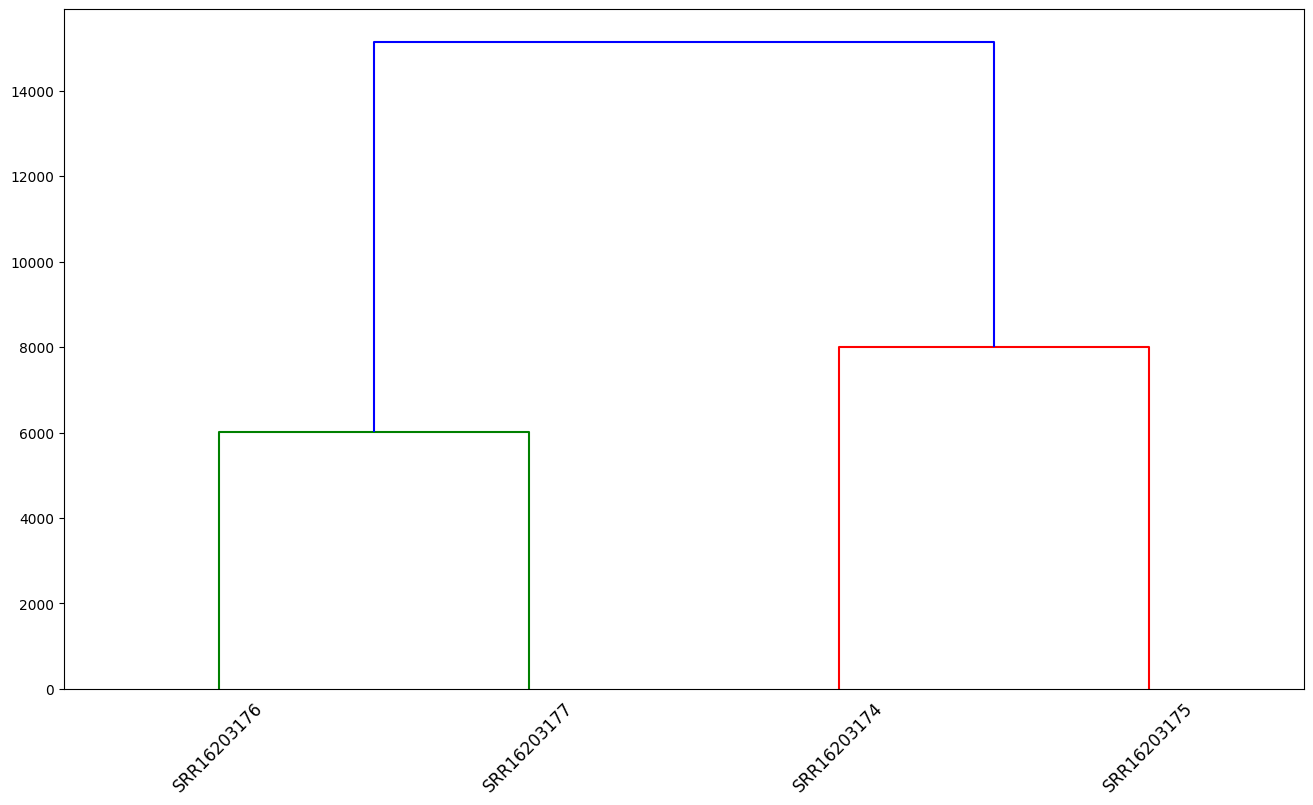

In [ ]:
#@title クラスタリング図を描画する
df_T = df_tpm.T

linkage_result = linkage(df_T , method = "ward" , metric = "euclidean")
fig = plt.figure(num = None , figsize = (16 , 9) , dpi = 100 , facecolor = "w" , edgecolor = "k")
ax = plt.subplot(111)
dendrogram(linkage_result , labels = list(df_T.index))
plt.xticks(rotation = 45)
plt.savefig(oud + exp_name + "クラスタリング.png")
plt.show()

In [ ]:
#@title データの確認
print("並び替え後の順番はこの通り")
df_data = df_tpm.copy(deep = True)

df_list = pd.DataFrame(list(df_data) , list(range(1 , len(list(df_data)) + 1 , 1))).T
df_list

並び替え後の順番はこの通り


,1,2,3,4
0,SRR16203174,SRR16203175,SRR16203176,SRR16203177


In [ ]:
# 平均行の追加
# 平均行の追加は、後ろから行う(追加された行でずれるため)
# 書き方は↓の通り
# df_data.insert(○○ , "Control" , df_data.iloc[: , △△:○○].mean(axis = 1).values)
df_data.insert(4 , "Control" , df_data.iloc[: , 2:4].mean(axis = 1).values)
df_data.insert(2 , "SFN" , df_data.iloc[: , 0:2].mean(axis = 1).values)
df_data.to_csv(oud + exp_name + "avetpm.csv")
df_data

,,SRR16203174,SRR16203175,SFN,SRR16203176,SRR16203177,Control
Geneid,product,,,,,,
ENSG00000000003,TSPAN6,19.495305,19.562800,19.529053,20.496433,18.929919,19.713176
ENSG00000000005,TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,DPM1,250.374827,264.105769,257.240298,241.269611,253.986941,247.628276
ENSG00000000457,SCYL3,8.512574,9.319981,8.916277,10.161786,10.186933,10.174359
ENSG00000000460,C1orf112,23.262501,22.975493,23.118997,26.814562,27.976978,27.395770
...,...,...,...,...,...,...,...
ENSG00000285990,AL589743.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000285991,AL355312.5,0.172143,0.059883,0.116013,0.000000,0.096302,0.048151
ENSG00000285992,AC120036.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#@title 平均を取る行数、平均列の列名の設定
#@markdown 平均を取る必要のある列の数だけ繰り返す<br>
#@markdown この際、列が追加されたことで列数が最初と異なるので注意<br>
#@markdown 間違えた場合は上のセルを実行することで元に戻すことができる
start = "1" #@param {type:"string"}
end = "1" #@param {type:"string"}
name = "BR1N" #@param {type:"string"}

start = int(start) -1
end = int(end)
df_data.insert(end , name , df_data.iloc[: , start:end].mean(axis = 1).values)
df_data.to_csv(oud + exp_name + "avetpm.csv")
df_data

,,ERR2603570ERR2603570,BR1N,ERR2603571ERR2603571,HaCaT,ERR2603572ERR2603572,BR1N_Zebularine,ERR2603573ERR2603573,HaCaT_Zebularine
Geneid,product,,,,,,,,
ENSG00000000003,TSPAN6,20.052576,20.052576,36.246714,36.246714,22.911952,22.911952,34.508131,34.508131
ENSG00000000005,TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,DPM1,212.306264,212.306264,325.767753,325.767753,249.576821,249.576821,269.189831,269.189831
ENSG00000000457,SCYL3,9.799655,9.799655,12.619392,12.619392,10.338851,10.338851,14.002711,14.002711
ENSG00000000460,C1orf112,35.779207,35.779207,36.939348,36.939348,41.558008,41.558008,41.130035,41.130035
...,...,...,...,...,...,...,...,...,...
ENSG00000285990,AL589743.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000285991,AL355312.5,0.059451,0.059451,0.368794,0.368794,0.000000,0.000000,0.098086,0.098086
ENSG00000285992,AC120036.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


出力ファイル<br>
・実験名_id_name.csv
　　　　→Gene_idとProduct(遺伝子名)との対応表<br>
・実験名_for_iDEP.csv
　　　　→Gene_idとカウント数との対応表<br>
・実験名_tpm.csv
　　　　　　→遺伝子名とTPM値を対応付けたcsvファイル